In [27]:
# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
rstate = np.random.default_rng(736109)
import dynesty

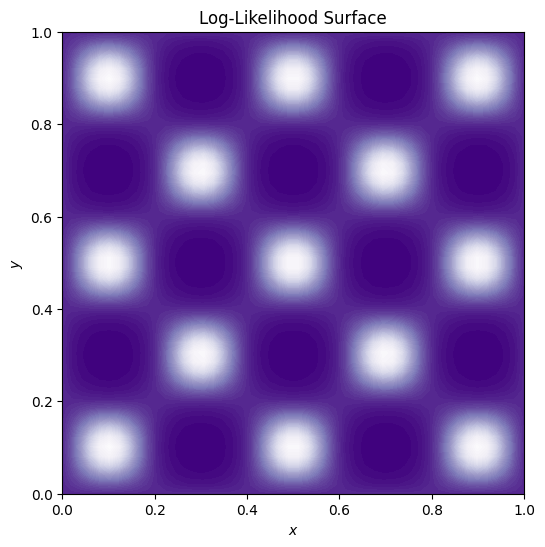

In [28]:
tmax = 5.0 * np.pi
def loglike(x):
    t = 2.0 * tmax * x - tmax
    return (2.0 + np.cos(t[0] / 2.0) * np.cos(t[1] / 2.0)) ** 5.0

# define the prior transform
def prior_transform(x):
    return x

# plot the log-likelihood surface
plt.figure(figsize=(6.,6.))
axes = plt.axes(aspect=1)
xx, yy = np.meshgrid(np.linspace(0., 1., 50),
                     np.linspace(0., 1., 50))
L = loglike(np.array([xx, yy]))
axes.contourf(xx, yy, L, 50, cmap=plt.cm.Purples_r)
plt.title('Log-Likelihood Surface')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

# ln(evidence)
lnz_truth = 235.88

In [29]:
dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=2,
                                        bound='multi', sample='unif', rstate=rstate)
dsampler.run_nested(dlogz_init=0.01, nlive_init=500, nlive_batch=500,
                    wt_kwargs={'pfrac': 0.0}, stop_kwargs={'pfrac': 0.0})
dres_z = dsampler.results

dres_z.summary()

print('test')

10159it [00:09, 1127.97it/s, batch: 1 | bound: 11 | nc: 1 | ncall: 59562 | eff(%): 17.056 | loglstar:   -inf < 243.000 < 241.437 | logz: 236.023 +/-  0.113 | stop:  0.977]       

Summary
niter: 10159
ncall: 59562
eff(%): 17.056
logz: 235.917 +/-  0.098
test


In [30]:
samples_equal0 = dynesty.utils.resample_equal(dres_z['samples'], dres_z['logwt'],rstate=rstate)

print(samples_equal0.shape)

logl = dres_z.logl

logl_equal0 = dynesty.utils.resample_equal(logl, dres_z['logwt'],rstate=rstate)

print(logl_equal0.shape)

def loglike(x):
    t = 2.0 * tmax * x - tmax
    return (2.0 + np.cos(t[:,0] / 2.0) * np.cos(t[:,1] / 2.0)) ** 5.0

import math,warnings
SQRTEPS = math.sqrt(float(np.finfo(np.float64).eps))

def resample_equal(results, rstate=None):
    logwt = results['logwt'] - results['logz'][-1]
    wt = np.exp(logwt)
    weights = wt / wt.sum()
    cumulative_sum = np.cumsum(weights)
    samples = results['samples']
    logl = results['logl']
    # if abs(cumulative_sum[-1] - 1.) > SQRTEPS:
    #     # same tol as in numpy's random.choice.
    #     # Guarantee that the weights will sum to 1.
    #     warnings.warn("Weights do not sum to 1 and have been renormalized.")
    cumulative_sum /= cumulative_sum[-1]
    # this ensures that the last element is strictly == 1

    # Make N subdivisions and choose positions with a consistent random offset.
    nsamples = len(weights)
    positions = (rstate.random() + np.arange(nsamples)) / nsamples

    # Resample the data.
    idx = np.zeros(nsamples, dtype=int)
    i, j = 0, 0
    while i < nsamples:
        if positions[i] < cumulative_sum[j]:
            idx[i] = j
            i += 1
        else:
            j += 1
    perm = rstate.permutation(nsamples)
    resampled_samples = samples[idx][perm]
    resampled_logl = logl[idx][perm]
    
    return resampled_samples, resampled_logl

    # return rstate.permutation(samples[idx])

samples_equal1, logl_equal1 = resample_equal(dres_z, rstate=rstate)

logl_equal2 = loglike(samples_equal1)

# print(logl_equal2.shape)

print(np.allclose(logl_equal1, logl_equal2))
print(np.allclose(samples_equal0, samples_equal1))

print(np.mean(samples_equal1,axis=0))
print(np.mean(samples_equal0,axis=0))

print(np.std(samples_equal1,axis=0))
print(np.std(samples_equal0,axis=0))

print(np.min(logl_equal1),np.max(logl_equal1))

(10159, 2)
(10159,)
True
False
[0.49715373 0.5021004 ]
[0.49807218 0.49563569]
[0.29361567 0.29573981]
[0.29221728 0.2946415 ]
230.4619307432811 242.99991950262054


/opt/homebrew/Caskroom/miniconda/base/envs/cosmo/lib/python3.12/site-packages/dynesty/utils.py:1033: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


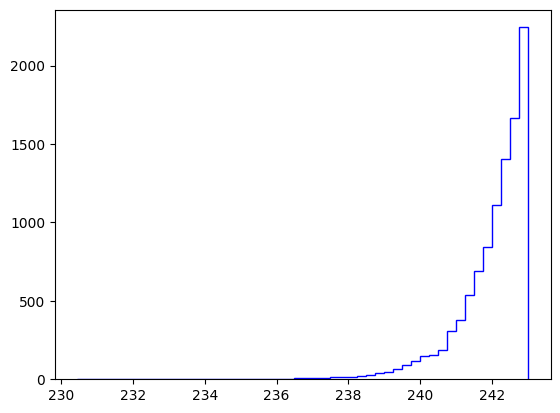

In [34]:
plt.hist(logl_equal1, bins=50, histtype='step', color='blue', label='resample_equal');

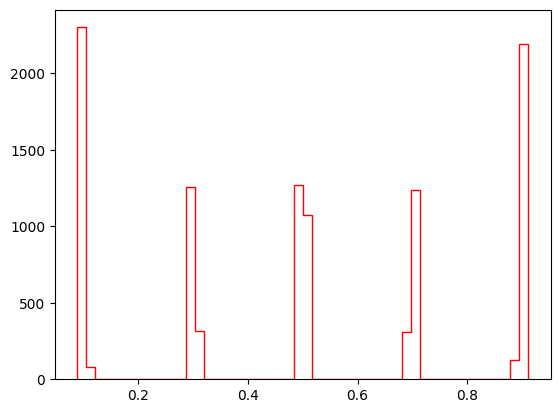

In [ ]:
plt.hist(samples_equal1[:,0], bins=50, histtype='step', color='red', label='resample_equal');

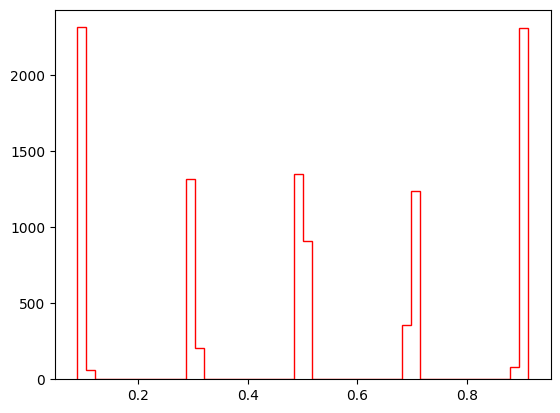

In [36]:
plt.hist(samples_equal1[:,1], bins=50, histtype='step', color='red', label='resample_equal');

In [ ]:
from dynesty import NestedSampler

li

sampler = NestedSampler(likelihood, prior, ndim, nlive=20*ndim)
sampler.run_nested(dlogz=0.5)
results = sampler.results()
print(results.summary())